In [17]:
import pandas as pd
import numpy as np
import time
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier

from nltk.corpus import stopwords
import nltk


#nltk.download('wordnet')
#nltk.download('omw-1.4')

#import spacy
#from nltk.corpus import stopwords

In [2]:

data=pd.read_csv("C:/Users/ranus/OneDrive/Bureau/DataScience/NLP/Corona_NLP_train.csv",parse_dates=True ,encoding='latin-1')
data

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...,...,...
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41157 entries, 0 to 41156
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   UserName       41157 non-null  int64 
 1   ScreenName     41157 non-null  int64 
 2   Location       32567 non-null  object
 3   TweetAt        41157 non-null  object
 4   OriginalTweet  41157 non-null  object
 5   Sentiment      41157 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.9+ MB


Les variables sont de types int et et object.
On remarque également des données manquantes dans la colonne Location.

In [4]:
is_int=list(data.select_dtypes("int64").columns)
for col in is_int:
    print(data[col].value_counts())

3799     1
31291    1
31233    1
31234    1
31235    1
        ..
17519    1
17520    1
17521    1
17522    1
44955    1
Name: UserName, Length: 41157, dtype: int64
48751    1
76243    1
76185    1
76186    1
76187    1
        ..
62471    1
62472    1
62473    1
62474    1
89907    1
Name: ScreenName, Length: 41157, dtype: int64


On remarque ScreenName et UserName sont des clefs de la dataframe. On peut donc en drop une et utiliser l'autre comme index

In [5]:
data=data.set_index("UserName")
data=data.drop("ScreenName",axis=1)
data

,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,
3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...
44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44953,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive


# Etude des données manquantes

In [6]:
data[data["Location"].isna()]


,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,
3802,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
3813,NaN,16-03-2020,ADARA Releases COVID-19 Resource Center for Tr...,Positive
3821,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
3822,NaN,16-03-2020,We have AMAZING CHEAP DEALS! FOR THE #COVID201...,Extremely Positive
...,...,...,...,...
44947,NaN,14-04-2020,UV light Sterilizer Sanitizer for your mask an...,Extremely Positive
44950,NaN,14-04-2020,@MrSilverScott you are definitely my man. I fe...,Extremely Positive
44952,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative


Les donnée manquantes semble aléatoire.

In [7]:
data.fillna("U",inplace=True)
data

,Location,TweetAt,OriginalTweet,Sentiment
UserName,,,,
3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
3800,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3802,U,16-03-2020,My food stock is not the only one which is emp...,Positive
3803,U,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
...,...,...,...,...
44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
44952,U,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
44953,U,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive


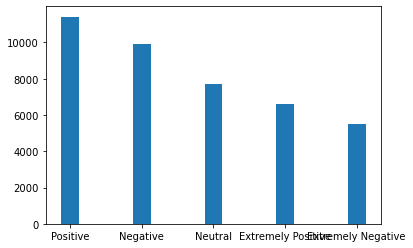

In [8]:
c=data["Sentiment"].value_counts()
plt.figure()
plt.bar(x=c.index,height=c.values,width=0.25)
plt.show()

In [9]:
#sw_nltk=stopwords.words('english')

In [10]:
target=data["Sentiment"]
data=data.drop("Sentiment",axis=1)
data


,Location,TweetAt,OriginalTweet
UserName,,,
3799,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
3800,UK,16-03-2020,advice Talk to your neighbours family to excha...
3801,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...
3802,U,16-03-2020,My food stock is not the only one which is emp...
3803,U,16-03-2020,"Me, ready to go at supermarket during the #COV..."
...,...,...,...
44951,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...
44952,U,14-04-2020,Response to complaint not provided citing COVI...
44953,U,14-04-2020,You know itÂs getting tough when @KameronWild...


In [11]:

#encodage de la variable cible
encoder=LabelEncoder()
encoder.fit_transform(target)


array([3, 4, 4, ..., 4, 3, 2])

In [12]:
t=time.time()
def traitement(liste):
    n=len(liste)
    car=["@","#",".","?","!"]
    for i in range(n):
        liste[i]=liste[i].lower()
    for word in liste:
        if word in car:
            del word
    #filtration des stop words
    liste1=list(filter(lambda word: word not in stopwords.words("english"),liste))
    
    #stemmatisation
    stemmer=nltk.stem.SnowballStemmer('english')
    liste2=[stemmer.stem(word) for word in liste1]
    
    #lemmatisation
    lemmatizer=nltk.stem.WordNetLemmatizer()
    liste3=[lemmatizer.lemmatize(word) for word in liste2]
    
    return liste3
        


#nltk.download('punkt')
n=data.shape[0]
#for i in range(n):
#   token=nltk.word_tokenize(data.iloc[i,2])
data["OriginalTweet"]=data['OriginalTweet'].apply(nltk.word_tokenize)
data
# convertie les majuscule en minuscule
data["OriginalTweet"]=data["OriginalTweet"].apply(traitement)
time.time()-t
# suppression des stopwords
#token_stop=list(filter(lambda token: token not in stopwords.word('english'),token_min))

#stemming
#stemmer=nltk.stem.SnowballStemmer('english')
#token_stem=[stemmer.stem(word) for word in token_stop]

#lemmatisation
#lemmatizer=nltk.stem.WordNetLemmatizer('english')
#token_lem=[lemmatizer.lemmatize(word) for word in token_stem]
#data.iloc[i,2]=token_lem

-322.37636828422546

In [13]:
data

,Location,TweetAt,OriginalTweet
UserName,,,
3799,London,16-03-2020,"[@, menyrbi, @, phil_gahan, @, chrisitv, http,..."
3800,UK,16-03-2020,"[advic, talk, neighbour, famili, exchang, phon..."
3801,Vagabonds,16-03-2020,"[coronavirus, australia, :, woolworth, give, e..."
3802,U,16-03-2020,"[food, stock, one, empti, ..., plea, ,, n't, p..."
3803,U,16-03-2020,"[,, readi, go, supermarket, #, covid19, outbre..."
...,...,...,...
44951,"Wellington City, New Zealand",14-04-2020,"[airlin, pilot, offer, stock, supermarket, she..."
44952,U,14-04-2020,"[respons, complaint, provid, cite, covid-19, r..."
44953,U,14-04-2020,"[know, itâ, get, tough, @, kameronwild, ratio..."


In [14]:
data_train,data_test,target_train,target_test=train_test_split(data,target,test_size=0.2)


In [15]:
param_grid={"max_depth":[2,3],"min_samples_leaf":[1,2,3]}
cv=3
rf=RandomForestClassifier()